In [1]:
from fastai.vision.all import *
import fastai
import timm
import albumentations as A
import torch
import pandas as pd
import numpy as np
torch.cuda.set_device(0)

In [33]:
import os
def create_csvValid(path):
    output_path = os.path.join(path,"..","df_test.csv")
    if (os.path.exists(output_path)):
        output_path_csv = open(output_path, "a")
    else:
        output_path_csv = open(output_path, "w")
        output_path_csv.write("images, class\n")

#         output_path_csv.write(head)

    lista_archivos = list(os.walk(path))
    lista_archivos.sort()
    for carpeta in lista_archivos:
#         print(carpeta[0])
        video = carpeta[0].split(os.path.sep)[-1]
        for files in carpeta[2]:
            if "images.csv" in files:
                leer = open(os.path.join(carpeta[0],files))
                leer.readline()
                for l in leer:
                    output_path_csv.write(video+os.path.sep+"images"+os.path.sep+l)
#                     print(l)

In [34]:
create_csvValid("./dataset38_Marco/test")

In [2]:
dfValid = pd.read_csv('./dataset38_Marco/df_train.csv')
dfTest = pd.read_csv('./dataset38_Marco/df_test.csv')

prueba = dfValid
prueba = prueba.iloc[np.random.permutation(len(prueba))]
prueba = prueba[0:int(len(prueba)*0.1)]
# In[6]:
# Aquí debería hacer dos df diferentes. Uno para entrenamiento y otro para validación. En este caso 
# usa para entrenar el set de entrenamiento y validación. Imagino que la división la hará por programa
# dfValid = dfValid[(dfValid.set == 'training') | (dfValid.set == 'validation')]

# Hay que modificar esto para que haya set de validación. Hacer un vector random y que esté entre las primeras 
# 0.1 posiciones si está se devuelve 
def is_valid(path):
    name = path[0]
#     return (dfValid[dfValid['challenge_id']==name])['set'].values[0]=='validation'
    return (dfValid[dfValid['images']==name]).values[0] in prueba.images.values
    
# In[13]:

def get_class(path):
    name = path[0]
    return (dfValid[dfValid['images']==name])['class']


In [3]:
dfValid.loc[:,'images']=dfValid['images'].apply(lambda x: "./dataset38_Marco/train/"+x)

In [4]:
dfTest.loc[:,'images']=dfTest['images'].apply(lambda x: "./dataset38_Marco/test/"+x)

In [5]:
dfValid['split'] = False
dfTest['split'] = True

In [6]:
dfTotal = pd.concat([dfValid,dfTest])

In [7]:
dfTotal.to_csv('df_total.csv')

In [8]:
def get_dls(presize=512,size=384,M=0,bs=16):
    db = DataBlock(blocks = (ImageBlock, CategoryBlock),
             splitter=ColSplitter(2),
             get_x = ColReader(0,suff='.jpg'),
             get_y=ColReader(1),
             item_tfms = [Resize(presize)], # CropPad(200,200)
             batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=False,flip_vert=False,
                  max_rotate=0.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                         Normalize.from_stats(*imagenet_stats)])
    dls = db.dataloaders(dfTotal,bs=bs)
    return dls

In [9]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnest50d_38FRAMES',monitor='cohen_kappa_score'),
    ReduceLROnPlateau(patience=10)
]

In [10]:
dlsTrain = get_dls()

learn = Learner(dlsTrain,timm.create_model('resnest50d',num_classes=13,pretrained=True),
                metrics=[accuracy,CohenKappa(weights='quadratic')], cbs = callbacks,
                loss_func= CrossEntropyLossFlat()).to_fp16()

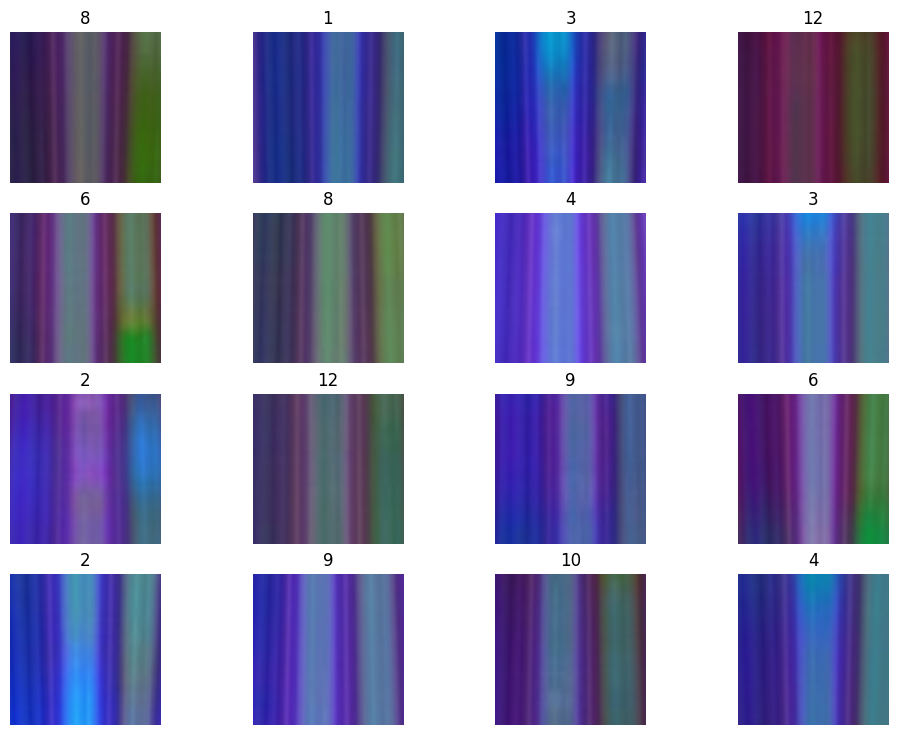

In [11]:
dlsTrain.show_batch(max_n=100, figsize=(12,9))

SuggestedLRs(valley=0.00010964782268274575)

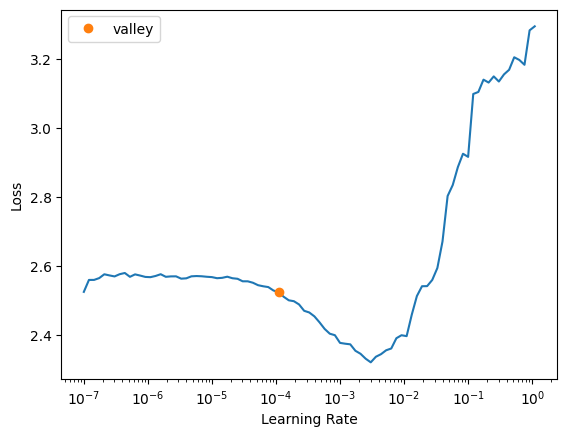

In [13]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,1.029155,1.158779,0.600828,0.783344,07:05


Better model found at epoch 0 with cohen_kappa_score value: 0.7833442593370201.


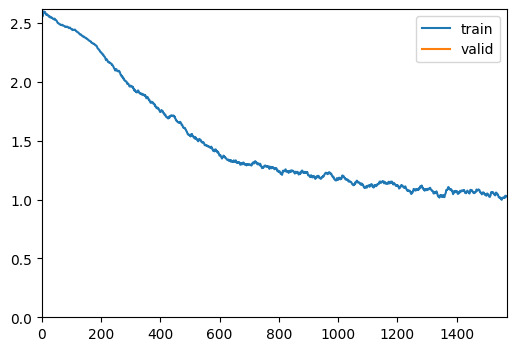

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,0.725850,0.933779,0.675900,0.824280,07:07
1,0.677594,0.911663,0.677453,0.812967,07:07
2,0.562447,0.905001,0.690525,0.831089,07:06
3,0.511477,0.954408,0.671628,0.816478,07:06
4,0.447906,1.013553,0.668781,0.821804,06:58
5,0.413241,0.997942,0.683277,0.822803,06:57
6,0.421201,1.030283,0.673570,0.817227,06:58
7,0.361204,1.069729,0.674217,0.806856,06:57


Better model found at epoch 0 with cohen_kappa_score value: 0.8242801695266085.


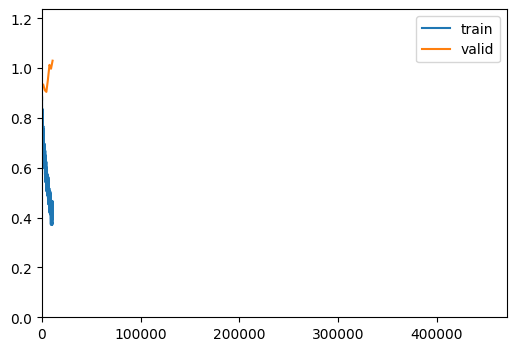

Better model found at epoch 2 with cohen_kappa_score value: 0.8310893057197557.
No improvement since epoch 2: early stopping


In [14]:
learn.fine_tune(300,base_lr=1e-04)

In [17]:
learn.load('resnest50d_38FRAMES')

In [18]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 splitter=ColSplitter('split'),
                 get_x = ColReader(0,suff='.jpg'),
                 get_y=ColReader(1),
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(dfTotal,bs=4)

In [19]:
learn.dls = dlsTest

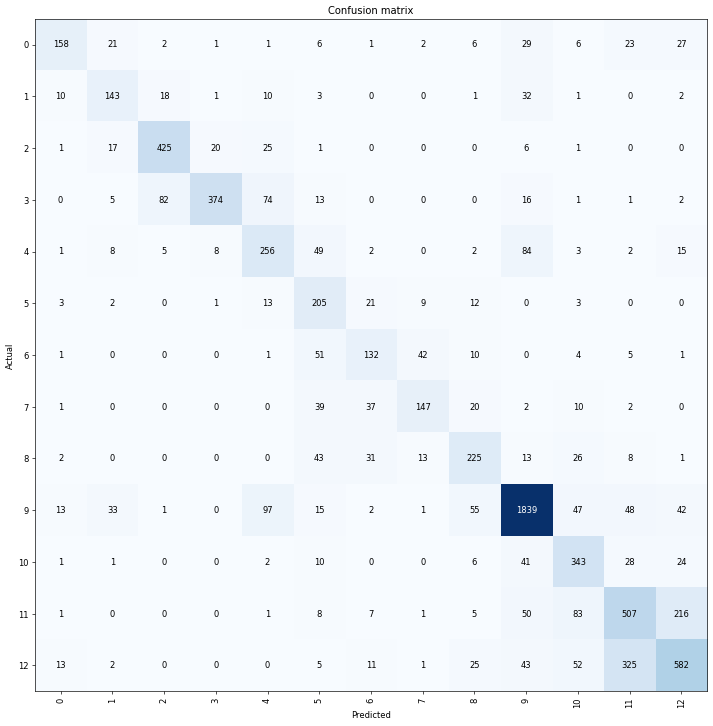

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [21]:
learn.validate()

IndexError: Exception occured in `SaveModelCallback` when calling event `after_epoch`:
	list index out of range

In [22]:
learn.export(fname='resnest50d_38FRAMES.pkl')

In [23]:
from sklearn.metrics import accuracy_score, top_k_accuracy_score, f1_score

preds,gt = learn.get_preds()

In [24]:
f1_score(np.argmax(preds,axis=1),gt,average='macro')

0.6487407690488433

In [25]:
accuracy_score(np.argmax(preds,axis=1),gt)

0.690654931400466

In [26]:
with open('resultados_Resnet50d_38FRAMES.txt', 'w') as f:
    f.write('El accuracy obtenido en test es:\n')
    f.write(str(accuracy_score(np.argmax(preds,axis=1),gt)))
    f.write('\nEl F1-score que tenemos en test es:\n')
    f.write(str(f1_score(np.argmax(preds,axis=1),gt,average='macro')))